In [1]:
import os
import numpy as np
import tensorflow as tf
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### Get Data

In [3]:
def load_img(path):
    img = skimage.io.imread(path)
    img = img / 255.0
    # print "Original Image Shape: ", img.shape
    # we crop image from center
    short_edge = min(img.shape[:2])
    yy = int((img.shape[0] - short_edge) / 2)
    xx = int((img.shape[1] - short_edge) / 2)
    crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
    # resize to 224, 224
    resized_img = skimage.transform.resize(crop_img, (224, 224))[None, :, :, :]   # shape [1, 224, 224, 3]
#    resized_img = skimage.transform.resize(crop_img, (32, 32))[None, :, :, :]   # shape [1, 32, 32, 3]
    return resized_img

In [4]:
def load_data(image_dir, part_dir_list):
    image_list = []
    label_list = []
    for k in range(len(part_dir_list)):
        part_name = part_dir_list[k]
        dir = image_dir + part_name
        for file in os.listdir(dir):
            if not file.lower().endswith('.jpg'):
                continue
            try:
                resized_img = load_img(os.path.join(dir, file))
            except OSError:
                continue
            image_list.append(resized_img)    # [1, height, width, depth] * n
            
            tag = np.zeros((1, len(part_dir_list)))
            tag[0][k] = 1
            label_list.append(tag)

#            if len(imgs[k]) == 400:        # only use 400 imgs to reduce my memory load
#                break
    
    image_data = np.concatenate(image_list, axis=0)
    label_data = np.concatenate(label_list, axis=0)
    
    return image_data, label_data

In [5]:
train_image_dir = 'train_img/'
test_image_dir = 'test_img/'

In [6]:
part_list = ['out', 'in']

In [7]:
train_dataset, label_dataset = load_data(train_image_dir, part_dir_list=part_list)
test_dataset, test_label = load_data(test_image_dir, part_dir_list=part_list)

/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [8]:
train_dataset.shape

(96, 224, 224, 3)

In [9]:
x = train_dataset[0:3].reshape(-1,224,224,3)
#x.shape
len(x)

3

In [10]:
y = label_dataset[0:3].reshape(-1,2)
y.shape

(3, 2)

In [11]:
label_dataset
label_dataset.shape
#label_dataset[2]

(96, 2)

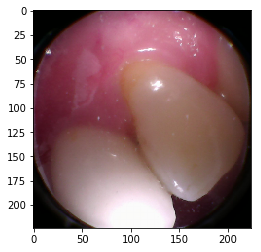

In [12]:
plt.imshow(train_dataset[7])

In [13]:
# Model

In [14]:
import tensorflow as tf

In [15]:
x = tf.placeholder(tf.float32,shape=[None,224,224,3])
#x = tf.placeholder(tf.float32,shape=[None,32,32,3])
y_true = tf.placeholder(tf.float32,shape=[None,len(part_list)])

In [16]:
hold_prob = tf.placeholder(tf.float32)

In [17]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [18]:
# create layers

In [19]:
convo_1 = convolutional_layer(x,shape=[4,4,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [20]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[4,4,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [21]:
#convo_2_flat = tf.reshape(convo_2_pooling, [-1, 8*8*64])  #example
convo_2_flat = tf.reshape(convo_2_pooling, [-1, 56*56*64])

In [22]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

In [23]:
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

In [24]:
y_pred = normal_full_layer(full_one_dropout,len(part_list))

In [25]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

In [26]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

In [27]:
init = tf.global_variables_initializer()

In [28]:
# grash session

In [29]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    index = 0

    for i in range(5000):
        batch_size = 2
        x_dataset = train_dataset[index:index+batch_size].reshape(-1,224,224,3)
#        x_dataset = train_dataset[index:index+batch_size].reshape(-1,32,32,3)
        y_dataset = label_dataset[index:index+batch_size].reshape(-1,len(part_list))
        
        index = (index+batch_size) % len(train_dataset)
        
        sess.run(train, feed_dict={x: x_dataset, y_true: y_dataset, hold_prob: 0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:test_dataset, y_true:test_label, hold_prob:1.0}))
            print('\n')

Currently on step 0
Accuracy is:
0.5




KeyboardInterrupt: 